In [111]:
import scanpy as sc
import GmGM
import matplotlib.pyplot as plt
import numpy as np
from scipy.sparse import csgraph

from sklearn.covariance import graphical_lasso as glasso
from sklearn import metrics
from sklearn.preprocessing import StandardScaler

import itertools

plt.style.use('tableau-colorblind10')

To get familiar with graphical models, we'll first run them on synthetic data.

The synthetic dataset below, "blobs", is a very simple dataset on which we can test
the capacity of our method to cluster cells.  It won't necessarily be indicative of
how methods perform on real data.

AnnData object with n_obs × n_vars = 700 × 11
    obs: 'blobs'

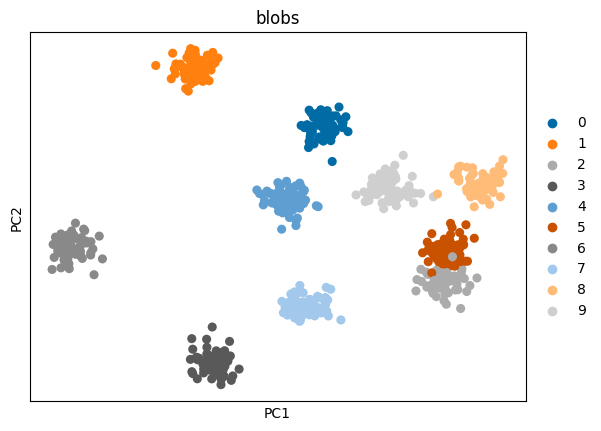

In [10]:
blob_data = sc.datasets.blobs(
    random_state=0,
    n_centers=10,
    n_observations=700,
    n_variables=11
)
display(blob_data)

#sc.pp.log1p(blob_data)
sc.pp.pca(blob_data)
sc.pl.pca(blob_data, color='blobs')

In [22]:
blob_data = GmGM.GmGM(
    blob_data,
    to_keep=0.05,
    min_edges={"obs": 5, "var": 3}, # to ensure the graphs have no singletons
)
print(blob_data.obsp['obs_gmgm_connectivities'])
blob_data

<Compressed Sparse Row sparse array of dtype 'float64'
	with 7392 stored elements and shape (700, 700)>
  Coords	Values
  (0, 0)	0.9989140033721924
  (0, 52)	0.0043642777018249035
  (0, 279)	0.0041461726650595665
  (0, 409)	0.004194192588329315
  (0, 534)	0.004302915185689926
  (0, 690)	0.004204769618809223
  (1, 1)	0.9995852112770081
  (1, 9)	0.003675126703456044
  (1, 137)	0.0034698708914220333
  (1, 159)	0.0034083430655300617
  (1, 215)	0.0034296654630452394
  (1, 668)	0.0034457803703844547
  (2, 2)	0.9949819445610046
  (2, 53)	0.008511118590831757
  (2, 182)	0.00843374989926815
  (2, 329)	0.008329211734235287
  (2, 478)	0.008322040550410748
  (2, 537)	0.008297626860439777
  (3, 3)	0.9967525005340576
  (3, 55)	0.006096246186643839
  (3, 194)	0.006175587885081768
  (3, 398)	0.006315808277577162
  (3, 420)	0.006278135348111391
  (3, 575)	0.006033758632838726
  (4, 4)	0.9982010722160339
  :	:
  (696, 629)	0.005116017535328865
  (696, 633)	0.004955108277499676
  (696, 635)	0.00485446862

AnnData object with n_obs × n_vars = 700 × 11
    obs: 'blobs', 'leiden_gmgm'
    uns: 'pca', 'blobs_colors', 'obs_neighbors_gmgm', 'var_neighbors_gmgm', 'leiden_gmgm', 'leiden_gmgm_colors'
    obsm: 'X_pca'
    varm: 'PCs'
    obsp: 'obs_gmgm_connectivities'
    varp: 'var_gmgm_connectivities'

The above code ran GmGM, which generates a graph.  We'll now cluster on this graph.

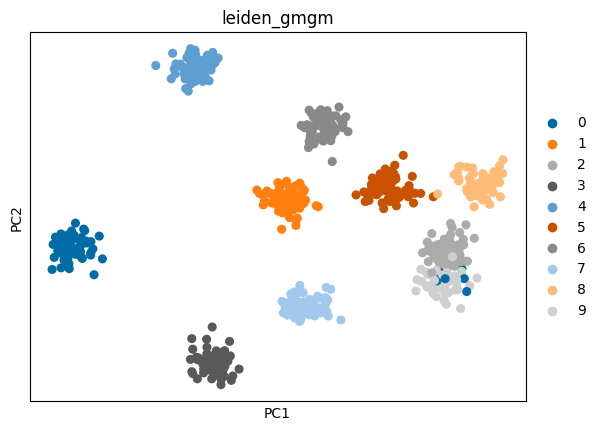

AnnData object with n_obs × n_vars = 700 × 11
    obs: 'blobs', 'leiden_gmgm'
    uns: 'pca', 'blobs_colors', 'obs_neighbors_gmgm', 'var_neighbors_gmgm', 'leiden_gmgm', 'leiden_gmgm_colors'
    obsm: 'X_pca'
    varm: 'PCs'
    obsp: 'obs_gmgm_connectivities'
    varp: 'var_gmgm_connectivities'

In [24]:
if 'leiden_gmgm_colors' in blob_data.uns:
    del blob_data.uns['leiden_gmgm_colors']
sc.tl.leiden(blob_data, obsp='obs_gmgm_connectivities', key_added='leiden_gmgm', resolution=0.1)
sc.pl.pca(blob_data, color='leiden_gmgm')
blob_data

The recovery seems perfect!  Let's confirm numerically that we recover well.

In [29]:
print(
    metrics.adjusted_rand_score(blob_data.obs['blobs'], blob_data.obs['leiden_gmgm']),
    metrics.homogeneity_score(blob_data.obs['blobs'], blob_data.obs['leiden_gmgm']),
    metrics.completeness_score(blob_data.obs['blobs'], blob_data.obs['leiden_gmgm']),
)

0.9757706769730835 0.98399743383868 0.9845571379139368


The above metrics look pretty good.  How does GLasso stack up?

In [79]:
nonzero = (blob_data.obsp['obs_gmgm_connectivities'] != 0).sum()
print(f"Nonzero elements: {nonzero}")

Nonzero elements: 7392


In [100]:
# We found this very finnicky to set up, hence our decisions in how to preprocess the data
# preprocessing we do to the data.  Without these steps, GLasso would fail to converge and/or
# throw errors.
data = blob_data.X
data = StandardScaler().fit_transform(data)
emp_cov = data @ data.T

# Let's use correlation rather than covariance, for better convergence
denominator = 1 / np.sqrt(np.diag(emp_cov)).reshape(1, -1)
emp_cov = denominator.T * emp_cov * denominator

try:
    goutput = glasso(
        emp_cov,
        alpha=0.984525, # manually tuned to give same #nonzero as GmGM
        max_iter=1000,
    )
except FloatingPointError:
    print("System is allegedly ill-conditioned.")
    goutput = None
print(f"Nonzero elements: {(goutput[1] != 0).sum()}")

blob_data.obsp["obs_glasso_connectivities"] = np.abs(goutput[1])
blob_data

Nonzero elements: 7392


AnnData object with n_obs × n_vars = 700 × 11
    obs: 'blobs', 'leiden_gmgm', 'leiden_glasso'
    uns: 'pca', 'blobs_colors', 'obs_neighbors_gmgm', 'var_neighbors_gmgm', 'leiden_gmgm', 'leiden_glasso', 'leiden_glasso_colors'
    obsm: 'X_pca'
    varm: 'PCs'
    obsp: 'obs_gmgm_connectivities', 'obs_glasso_connectivities'
    varp: 'var_gmgm_connectivities'

In [109]:
print("Number of connected components: ", csgraph.connected_components(goutput[1])[0])
sc.tl.leiden(blob_data, obsp='obs_glasso_connectivities', key_added='leiden_glasso', resolution=0.1)
print(
    metrics.adjusted_rand_score(blob_data.obs['blobs'], blob_data.obs['leiden_glasso']),
    metrics.homogeneity_score(blob_data.obs['blobs'], blob_data.obs['leiden_glasso']),
    metrics.completeness_score(blob_data.obs['blobs'], blob_data.obs['leiden_glasso']),
)

Number of connected components:  105
0.5770872550489027 1.0 0.5829952881017999


Unlike GmGM, GLasso splits the "cells" up into 105 different disjoint graphs; plotting this is not useful, so
we'll just rely on the metrics given above to assess our performance.

Let's check another metric - percentage of edges between two of the same class.  This is independent of our clustering
algorithm.

In [117]:
# Iterate through every pair (i, j) such that (i < j)
good_edges = 0
total_edges = 0
for (i, j) in itertools.combinations(range(700), 2):
    edge_val = blob_data.obsp['obs_gmgm_connectivities'][i, j]
    if edge_val == 0:
        continue
    total_edges += 1
    if blob_data.obs["blobs"].iloc[i] == blob_data.obs["blobs"].iloc[j]:
        good_edges += 1

print(good_edges / total_edges)

for (i, j) in itertools.combinations(range(700), 2):
    edge_val = blob_data.obsp['obs_glasso_connectivities'][i, j]
    if edge_val == 0:
        continue
    total_edges += 1
    if blob_data.obs["blobs"].iloc[i] == blob_data.obs["blobs"].iloc[j]:
        good_edges += 1

print(good_edges / total_edges)

0.9814704124327556
0.9907352062163778


By this metric, GLasso edges out GmGM.  This is not unsurprising; GmGM is a more complicated algorithm, built for the case where our data is not independent.  This synthetic data is independent, and as such GLasso performs well and GmGM likely slightly `overfits'.